## Compare reconstruction to quad scan

In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, CustomLoss, get_data, get_datasets
from utils import calc_rms_size

import sys
sys.path.append("../")

folder = "../../test_case_4/"
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images)
gt_initial_beam = torch.load(folder + "ground_truth_dist.pt")

# transpose the images to orient right
#all_images = torch.transpose(all_images, -2, -1)

from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

gt_initial_beam = Beam(gt_initial_beam, **defaults)


bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, "alpha_1e-3")
ensemble = ensemble
ensemble.cuda();

torch.Size([20, 1, 200, 200])
torch.Size([20, 1])


In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = None#dist.sample([100000]).cuda()
    
        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1])[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()
        #model_pred = torch.transpose(model_pred, -2, -1)
        
        torch.save(model_pred, "all_pred_images.pt")
    else:
        model_pred = torch.load("all_pred_images.pt")


In [5]:
print(all_images.shape)
model_pred.shape

torch.Size([20, 1, 200, 200])


torch.Size([20, 5, 200, 200])

torch.Size([20, 5, 200, 200])
torch.Size([20, 1, 200, 200])


C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


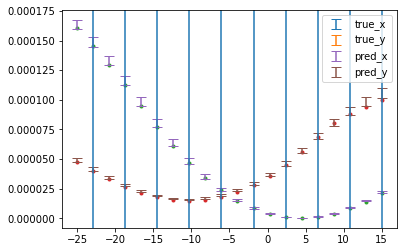

In [6]:
# plot quad scan
means, variances = calc_rms_size(xx, all_images.cpu())


fig,ax = plt.subplots()
k = all_k[:, 0].cpu()
mean_variance = torch.mean(variances, dim=-2).cpu()
error_variance = torch.std(variances, dim=-2).cpu()

ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='', label="true_x")
ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='', label="true_y")
ax.plot(k, mean_variance[...,0],'.')
ax.plot(k, mean_variance[...,1],'.')

print(model_pred.shape)
print(all_images.shape)
pmeans, pvariances = calc_rms_size(xx, model_pred)

mean_pvariance = torch.mean(pvariances, dim=-2)
error_pvariance = torch.std(pvariances, dim=-2)

#ax.plot(k, pvariances[...,0],'o')
#ax.plot(k, pvariances[...,1],'o')

ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="pred_x")
ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='', label="pred_y")

for ele in range(1,20,2):
    ax.axvline(all_k[ele,0].cpu())
    
ax.legend()


In [7]:
# emittance for x
from quad_scan_emittance_fit import EmittanceQuadScan
from torch.nn.functional import mse_loss

# note we initially train on a subset of the data to prevent sinking into a local
# extrema
idx = slice(10,21,1)

model = EmittanceQuadScan(torch.tensor(1.0), torch.tensor(0.1))
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.1)

for i in range(1000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(k.cpu()[idx])
    # Calc loss and backprop gradients
    loss = mse_loss(output, mean_variance[...,0].cpu()[idx])
    loss.backward()
    #print(loss)
    optimizer.step()

# train on all the data
for i in range(1000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(k.cpu())
    # Calc loss and backprop gradients
    loss = mse_loss(output, mean_variance[...,0].cpu())
    loss.backward()
    #print(loss)
    optimizer.step()

print(model.emittance)
print(list(model.named_parameters()))

# predict beam variance
gauss_x_var = model(k)

tensor([5.5541e-06], grad_fn=<SqrtBackward0>)
[('s11', Parameter containing:
tensor([1.8338e-05], requires_grad=True)), ('s12', Parameter containing:
tensor([-2.8023e-05], requires_grad=True)), ('s22', Parameter containing:
tensor([4.4505e-05], requires_grad=True))]


In [8]:
# emittance for y
# note we initially train on a subset of the data to prevent sinking into a local
# extrema
idx = slice(0,10,1)

model = EmittanceQuadScan(torch.tensor(1.0), torch.tensor(0.1))
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.1)

for i in range(1000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(k.cpu()[idx])
    # Calc loss and backprop gradients
    loss = mse_loss(output, mean_variance[...,1].cpu()[idx])
    loss.backward()
    #print(loss)
    optimizer.step()

# train on all the data
for i in range(1000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(k.cpu())
    # Calc loss and backprop gradients
    loss = mse_loss(output, mean_variance[...,1].cpu())
    loss.backward()
    #print(loss)
    optimizer.step()

print(model.emittance)
print(list(model.named_parameters()))

# predict beam variance
gauss_y_var = model(k)

tensor([1.5859e-05], grad_fn=<SqrtBackward0>)
[('s11', Parameter containing:
tensor([1.3903e-05], requires_grad=True)), ('s12', Parameter containing:
tensor([1.3726e-06], requires_grad=True)), ('s22', Parameter containing:
tensor([1.8226e-05], requires_grad=True))]


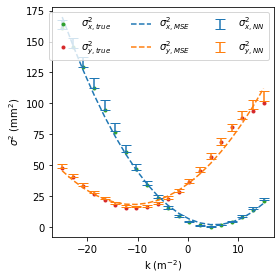

In [9]:
fig,ax = plt.subplots()
fig.set_size_inches(4,4)
scale_factor = 1e6
plot_mean_variance = mean_variance*scale_factor
plot_mean_pvariance = mean_pvariance * scale_factor
plot_error_pvariance = error_pvariance * scale_factor
plot_error_variance = error_variance * scale_factor
plot_gauss_x_var = gauss_x_var*scale_factor
plot_gauss_y_var = gauss_y_var*scale_factor

ax.plot(k, plot_mean_variance[...,0],'.C2',label="$\sigma_{x, true}^2$")
ax.plot(k, plot_mean_variance[...,1],'.C3',label="$\sigma_{y, true}^2$")


ax.errorbar(k,
            plot_mean_pvariance[...,0],
            plot_error_pvariance[...,0],
            capsize=5,ls='', label="$\sigma_{x, NN}^2$")
ax.errorbar(k,
            plot_mean_pvariance[...,1],
            plot_error_pvariance[...,1],
            capsize=5,ls='', label="$\sigma_{y, NN}^2$"
            )

# print gaussian approx pred
ax.plot(k, plot_gauss_x_var.detach(),"--C0", label="$\sigma_{x, MSE}^2$")
ax.plot(k, plot_gauss_y_var.detach(),"--C1", label="$\sigma_{y, MSE}^2$")

ax.set_ylabel("$\sigma^2$ (mm$^2$)")
ax.set_xlabel("k (m$^{-2}$)")
ax.legend(ncol=3)
fig.tight_layout()


In [10]:
k[1]

tensor(-22.8947)